# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [66]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA

from loguru import logger

In [67]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [68]:
fifa = pd.read_csv("fifa.csv")

In [69]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [70]:
# Sua análise começa aqui.

fifa.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [71]:
fifa.shape

(18207, 37)

In [72]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              18207 non-null  int64  
 1   Overall          18207 non-null  int64  
 2   Potential        18207 non-null  int64  
 3   Crossing         18159 non-null  float64
 4   Finishing        18159 non-null  float64
 5   HeadingAccuracy  18159 non-null  float64
 6   ShortPassing     18159 non-null  float64
 7   Volleys          18159 non-null  float64
 8   Dribbling        18159 non-null  float64
 9   Curve            18159 non-null  float64
 10  FKAccuracy       18159 non-null  float64
 11  LongPassing      18159 non-null  float64
 12  BallControl      18159 non-null  float64
 13  Acceleration     18159 non-null  float64
 14  SprintSpeed      18159 non-null  float64
 15  Agility          18159 non-null  float64
 16  Reactions        18159 non-null  float64
 17  Balance     

In [73]:
#Criando um dataframe auxiliar para analisar a consistencia das variaveis
aux = pd.DataFrame({'colunas' : fifa.columns,
                    'tipo': fifa.dtypes,
                    'missing' : fifa.isna().sum(),
                    'size' : fifa.shape[0],
                    'unicos': fifa.nunique()})
aux

,colunas,tipo,missing,size,unicos
Age,Age,int64,0,18207,29
Overall,Overall,int64,0,18207,48
Potential,Potential,int64,0,18207,47
Crossing,Crossing,float64,48,18207,89
Finishing,Finishing,float64,48,18207,93
HeadingAccuracy,HeadingAccuracy,float64,48,18207,91
ShortPassing,ShortPassing,float64,48,18207,85
Volleys,Volleys,float64,48,18207,87
Dribbling,Dribbling,float64,48,18207,94
Curve,Curve,float64,48,18207,89


In [74]:
fifa.dropna(inplace= True)

In [75]:
fifa.isna().sum()

Age                0
Overall            0
Potential          0
Crossing           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [76]:
fifa.corr()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
Age,1.000000,0.453069,-0.252281,0.130545,0.068660,0.147183,0.132894,0.142472,0.010166,0.143276,...,0.139535,0.391023,0.142817,0.119745,0.103089,0.101277,0.106419,0.104964,0.116402,0.103313
Overall,0.453069,1.000000,0.661180,0.394972,0.332515,0.340776,0.502550,0.391338,0.372426,0.419491,...,0.341429,0.727655,0.286505,0.252629,0.222811,-0.025937,-0.025062,-0.029372,-0.017674,-0.023276
Potential,-0.252281,0.661180,1.000000,0.246319,0.243355,0.200988,0.369189,0.254906,0.315019,0.279944,...,0.224281,0.440008,0.162801,0.143564,0.128980,-0.053446,-0.054672,-0.059061,-0.052589,-0.053341
Crossing,0.130545,0.394972,0.246319,1.000000,0.655300,0.469507,0.809660,0.690339,0.856647,0.833105,...,0.645805,0.575446,0.443101,0.428963,0.409961,-0.663053,-0.660193,-0.659767,-0.660160,-0.662539
Finishing,0.068660,0.332515,0.243355,0.655300,1.000000,0.473427,0.661830,0.882675,0.824337,0.759229,...,0.837827,0.533414,0.024218,-0.033023,-0.071811,-0.588752,-0.587145,-0.583268,-0.584852,-0.586913
HeadingAccuracy,0.147183,0.340776,0.200988,0.469507,0.473427,1.000000,0.640091,0.505639,0.550750,0.440846,...,0.551978,0.507208,0.583123,0.561063,0.533643,-0.750417,-0.749888,-0.746444,-0.744443,-0.748895
ShortPassing,0.132894,0.502550,0.369189,0.809660,0.661830,0.640091,1.000000,0.698309,0.843722,0.775398,...,0.676063,0.685137,0.559576,0.541131,0.508644,-0.729785,-0.728024,-0.724381,-0.723782,-0.728721
Volleys,0.142472,0.391338,0.254906,0.690339,0.882675,0.505639,0.698309,1.000000,0.809639,0.807285,...,0.829257,0.595281,0.120919,0.072788,0.035457,-0.590808,-0.588668,-0.584954,-0.586131,-0.588670
Dribbling,0.010166,0.372426,0.315019,0.856647,0.824337,0.550750,0.843722,0.809639,1.000000,0.842652,...,0.769594,0.597498,0.336072,0.301251,0.273963,-0.754625,-0.753181,-0.749816,-0.751348,-0.754341
Curve,0.143276,0.419491,0.279944,0.833105,0.759229,0.440846,0.775398,0.807285,0.842652,1.000000,...,0.751833,0.616532,0.289529,0.261481,0.232869,-0.606286,-0.603141,-0.600266,-0.603540,-0.604960


In [77]:
pca = PCA()
pca.fit(fifa) 
print(np.matrix(pca.components_))

[[-6.16388751e-03 -3.70623864e-02 -2.27401748e-02 ...  1.91129889e-01
   1.97401130e-01  2.08994083e-01]
 [ 8.87203494e-03  1.58367355e-04 -7.78142440e-03 ... -5.14942445e-02
  -5.14745248e-02 -5.52340572e-02]
 [ 9.84206291e-02  2.04339855e-01  9.50820413e-02 ...  2.93758717e-01
   3.07480231e-01  3.20998523e-01]
 ...
 [ 1.36565256e-03  7.18377075e-03 -7.50009269e-04 ... -4.84151364e-02
  -4.47127432e-02  6.56387319e-01]
 [ 5.53542477e-01  6.30337955e-01  2.43391671e-01 ...  1.16015772e-02
  -1.80358372e-01 -1.53714829e-02]
 [ 5.64377667e-01 -6.46636967e-01  5.04199457e-01 ...  7.95845835e-03
  -1.18786610e-02  3.10873931e-02]]


In [78]:
evr = pca.explained_variance_ratio_
evr

array([5.65280555e-01, 1.81025219e-01, 5.95283391e-02, 4.34269284e-02,
       2.63532326e-02, 1.20707695e-02, 1.03550495e-02, 8.52951131e-03,
       7.87862979e-03, 7.20416677e-03, 7.18180297e-03, 6.32893542e-03,
       5.19242286e-03, 4.90798293e-03, 4.74209042e-03, 4.62772008e-03,
       4.25173246e-03, 3.86288432e-03, 3.76588448e-03, 3.75092615e-03,
       3.47815213e-03, 3.26730709e-03, 3.03137944e-03, 2.97415845e-03,
       2.56797543e-03, 2.30353342e-03, 2.14815132e-03, 1.56135904e-03,
       1.55351696e-03, 1.08664227e-03, 1.06824189e-03, 1.05891525e-03,
       9.58143746e-04, 8.89209394e-04, 8.59732430e-04, 7.34611045e-04,
       1.94187517e-04])

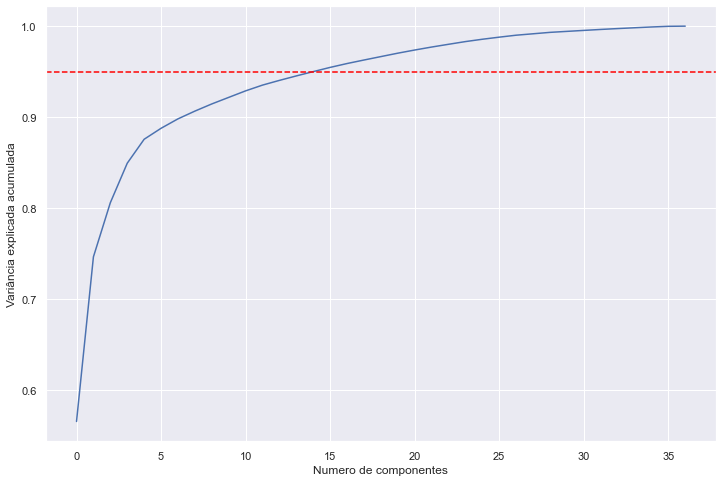

In [79]:
g = sns.lineplot(np.arange(len(evr)), np.cumsum(evr))
g.axes.axhline(0.95, ls="--", color="red")
plt.xlabel('Numero de componentes')
plt.ylabel('Variância explicada acumulada');

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [80]:
def q1():
    pca = PCA() 
    pca.fit_transform(fifa) # fit_transform para centralizar os dados de entrada
    evr = pca.explained_variance_ratio_
    return float(round(evr[0],3))

In [81]:
q1()

0.565

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [82]:
def q2():
    pca_095 = PCA(n_components=0.95)
    var_095 = pca_095.fit_transform(fifa)
    return var_095.shape[1]

In [83]:
q2()

15

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [84]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [85]:
def q3():
    pca_2comp  = PCA(n_components=2) # reduzindo para dois componentes principais
    pca_2comp .fit(fifa)  # Passo os dados para serem reduzidos 
    # Tendo a variância de cada coluna para os dois principais componentes eu aplico uma multiplicação de matrizes 
    # para achar os principais componentes de x
    pc = pca.components_.dot(x)
    
    return (round(pc[0],3),round(pc[1],3))

In [86]:
q3()

(186.556, -6.592)

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

A feature a ser considerada como target é a 'Overall' que incorpora todos os atributos com ênfase em cada posição

In [92]:
def q4():
    X_train = fifa.drop(columns='Overall')
    y = fifa['Overall']
    reg = LinearRegression()
    rfe = RFE(reg, n_features_to_select=5)
    selector = rfe.fit(X_train, y)
    return list(X_train.columns[selector.support_])

In [93]:
q4()

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']